In [9]:
import os
import shutil
from pathlib import Path

# Se dados estão em notebooks/, move para raiz
if os.path.exists('notebooks/data/processed'):
    os.makedirs('data/processed', exist_ok=True)
    for file in os.listdir('notebooks/data/processed'):
        src = f'notebooks/data/processed/{file}'
        dst = f'data/processed/{file}'
        if os.path.isfile(src):
            shutil.copy(src, dst)
    print("✓ Dados movidos de notebooks/data/processed para data/processed/")

# Se estiver em notebooks/, suba para raiz
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

print(f"Working directory: {os.getcwd()}")

Working directory: /home/maricarminate/Projetos/anomaly-detector


In [10]:
# ============================================================================
# CARREGAR DADOS DO DIA 1
# ============================================================================

print("=" * 70)
print("DIA 2: MÉTODOS ESTATÍSTICOS PARA DETECÇÃO DE ANOMALIAS")
print("=" * 70)

train = pd.read_csv('data/processed/nyc_taxi_train.csv', parse_dates=['timestamp'])  # ← CORRETO
test = pd.read_csv('data/processed/nyc_taxi_test.csv', parse_dates=['timestamp'])

print(f"\nDados carregados:")
print(f"  Treino: {len(train)} pontos")
print(f"  Teste: {len(test)} pontos")

DIA 2: MÉTODOS ESTATÍSTICOS PARA DETECÇÃO DE ANOMALIAS

Dados carregados:
  Treino: 3494 pontos
  Teste: 874 pontos


In [11]:
#============================================================================
# MÉTODO 1: Z-SCORE
# ============================================================================

print("\n" + "=" * 70)
print("MÉTODO 1: Z-SCORE")
print("=" * 70)

def zscore_detector(train_data, test_data, threshold=3):
    """
    Z-score mede quantos desvios padrão um ponto está da média.
    Anomalia: |z-score| > threshold (padrão: 3)
    
    Lógica:
    - Calcular média e std do treino
    - Para cada ponto no teste: z = (valor - média) / std
    - Se |z| > threshold → anomalia
    """
    mean = train_data['value'].mean()
    std = train_data['value'].std()
    
    # Calcular z-scores
    z_scores = np.abs((test_data['value'] - mean) / std)
    
    # Detectar anomalias
    predictions = (z_scores > threshold).astype(int)
    
    return predictions, z_scores, mean, std

zscore_pred, zscore_scores, zscore_mean, zscore_std = zscore_detector(train, test, threshold=3)
anomalies_zscore = test[zscore_pred == 1].copy()

print(f"\nParâmetros:")
print(f"  Média do treino: {zscore_mean:.2f}")
print(f"  Desvio padrão: {zscore_std:.2f}")
print(f"  Threshold: 3 desvios padrão")
print(f"\nAnomalias detectadas: {zscore_pred.sum()} ({100*zscore_pred.sum()/len(test):.2f}%)")



MÉTODO 1: Z-SCORE

Parâmetros:
  Média do treino: 337.16
  Desvio padrão: 154.78
  Threshold: 3 desvios padrão

Anomalias detectadas: 0 (0.00%)


In [12]:
# ============================================================================
# MÉTODO 2: IQR (Interquartile Range)
# ============================================================================

print("\n" + "=" * 70)
print("MÉTODO 2: IQR (INTERQUARTILE RANGE)")
print("=" * 70)

def iqr_detector(train_data, test_data, multiplier=1.5):
    """
    IQR usa quartis (Q1, Q3) para definir limites normais.
    
    Lógica:
    - Q1 = 25º percentil, Q3 = 75º percentil
    - IQR = Q3 - Q1
    - Limite inferior = Q1 - 1.5 * IQR
    - Limite superior = Q3 + 1.5 * IQR
    - Anomalia: valor < limite_inferior OU valor > limite_superior
    """
    Q1 = train_data['value'].quantile(0.25)
    Q3 = train_data['value'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Detectar anomalias
    predictions = ((test_data['value'] < lower_bound) | (test_data['value'] > upper_bound)).astype(int)
    
    return predictions, lower_bound, upper_bound, Q1, Q3, IQR

iqr_pred, iqr_lower, iqr_upper, q1, q3, iqr = iqr_detector(train, test, multiplier=1.5)
anomalies_iqr = test[iqr_pred == 1].copy()

print(f"\nParâmetros:")
print(f"  Q1 (25º percentil): {q1:.2f}")
print(f"  Q3 (75º percentil): {q3:.2f}")
print(f"  IQR: {iqr:.2f}")
print(f"  Limite inferior: {iqr_lower:.2f}")
print(f"  Limite superior: {iqr_upper:.2f}")
print(f"\nAnomalias detectadas: {iqr_pred.sum()} ({100*iqr_pred.sum()/len(test):.2f}%)")




MÉTODO 2: IQR (INTERQUARTILE RANGE)

Parâmetros:
  Q1 (25º percentil): 220.25
  Q3 (75º percentil): 448.75
  IQR: 228.50
  Limite inferior: -122.50
  Limite superior: 791.50

Anomalias detectadas: 0 (0.00%)


In [13]:
# ============================================================================
# MÉTODO 3: MOVING AVERAGE (MA)
# ============================================================================


print("\n" + "=" * 70)
print("MÉTODO 3: MOVING AVERAGE (MA)")
print("=" * 70)

def moving_average_detector(test_data, window=24, threshold=2):
    """
    Moving Average detecta desvios da tendência local.
    
    Lógica:
    - Calcular média móvel com janela de 'window' períodos
    - Erro = valor real - média móvel
    - Anomalia: |erro| > threshold * std(erros)
    """
    ma = test_data['value'].rolling(window=window, center=True).mean()
    error = test_data['value'] - ma
    
    # Usar std dos erros como baseline
    error_std = error.std()
    
    # Detectar anomalias
    predictions = (np.abs(error) > threshold * error_std).astype(int)
    predictions = predictions.fillna(0).astype(int)  # Fill NaN from rolling
    
    return predictions, ma, error, error_std

ma_pred, ma_values, ma_error, ma_error_std = moving_average_detector(test, window=24, threshold=2)
anomalies_ma = test[ma_pred == 1].copy()

print(f"\nParâmetros:")
print(f"  Janela (window): 24 horas")
print(f"  Threshold: 2 × desvio padrão do erro")
print(f"  Desvio padrão do erro: {ma_error_std:.2f}")
print(f"\nAnomalias detectadas: {ma_pred.sum()} ({100*ma_pred.sum()/len(test):.2f}%)")


MÉTODO 3: MOVING AVERAGE (MA)

Parâmetros:
  Janela (window): 24 horas
  Threshold: 2 × desvio padrão do erro
  Desvio padrão do erro: 132.70

Anomalias detectadas: 30 (3.43%)


In [14]:
# ============================================================================
# MÉTODO 4: EXPONENTIAL SMOOTHING (EWMA)
# ============================================================================


print("\n" + "=" * 70)
print("MÉTODO 4: EXPONENTIAL WEIGHTED MOVING AVERAGE (EWMA)")
print("=" * 70)

def ewma_detector(test_data, span=24, threshold=2):
    """
    EWMA dá mais peso aos pontos recentes (adaptativo a mudanças).
    
    Lógica:
    - Calcular EWMA com fator de suavização (span)
    - Erro = valor real - EWMA
    - Anomalia: |erro| > threshold * std(erros)
    """
    ewma = test_data['value'].ewm(span=span, adjust=False).mean()
    error = test_data['value'] - ewma
    
    # Usar std dos erros como baseline
    error_std = error.std()
    
    # Detectar anomalias
    predictions = (np.abs(error) > threshold * error_std).astype(int)
    
    return predictions, ewma, error, error_std

ewma_pred, ewma_values, ewma_error, ewma_error_std = ewma_detector(test, span=24, threshold=2)
anomalies_ewma = test[ewma_pred == 1].copy()

print(f"\nParâmetros:")
print(f"  Span (alfa): 24 períodos")
print(f"  Threshold: 2 × desvio padrão do erro")
print(f"  Desvio padrão do erro: {ewma_error_std:.2f}")
print(f"\nAnomalias detectadas: {ewma_pred.sum()} ({100*ewma_pred.sum()/len(test):.2f}%)")




MÉTODO 4: EXPONENTIAL WEIGHTED MOVING AVERAGE (EWMA)

Parâmetros:
  Span (alfa): 24 períodos
  Threshold: 2 × desvio padrão do erro
  Desvio padrão do erro: 123.07

Anomalias detectadas: 34 (3.89%)



GERANDO VISUALIZAÇÕES
✓ Salvo: outputs/plots/02_baselines_methods.png


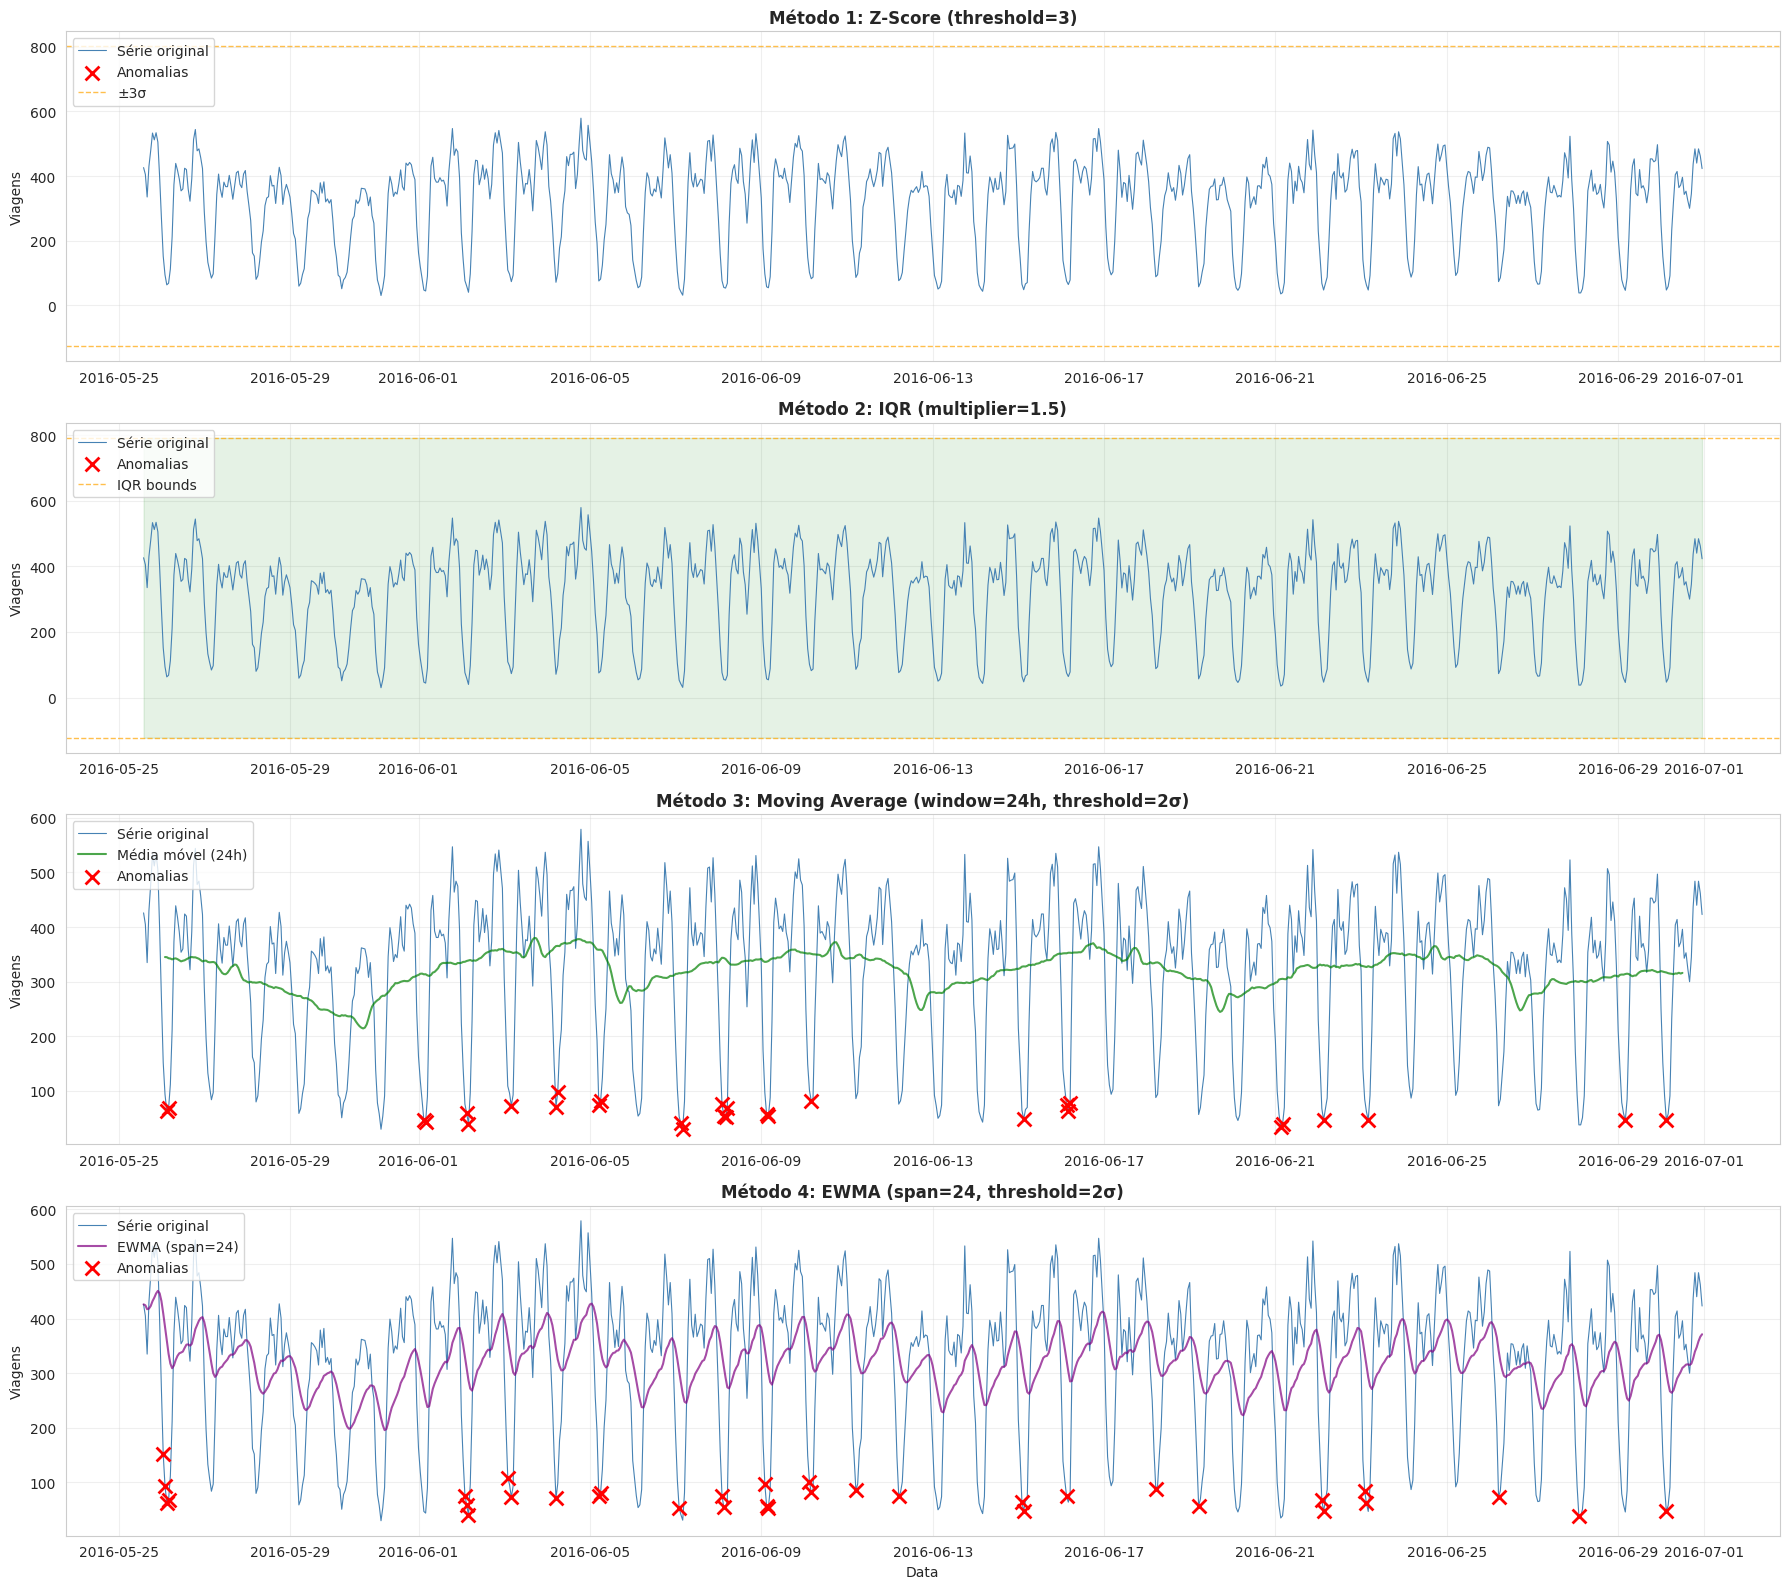

In [15]:
# ============================================================================
# VISUALIZAÇÕES COMPARATIVAS
# ============================================================================

print("\n" + "=" * 70)
print("GERANDO VISUALIZAÇÕES")
print("=" * 70)

fig, axes = plt.subplots(4, 1, figsize=(18, 16))

# MÉTODO 1: Z-Score
axes[0].plot(test['timestamp'], test['value'], label='Série original', linewidth=0.8, color='steelblue')
axes[0].scatter(anomalies_zscore['timestamp'], anomalies_zscore['value'], 
               color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[0].axhline(y=zscore_mean + 3*zscore_std, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='±3σ')
axes[0].axhline(y=zscore_mean - 3*zscore_std, color='orange', linestyle='--', linewidth=1, alpha=0.7)
axes[0].set_title('Método 1: Z-Score (threshold=3)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Viagens')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# MÉTODO 2: IQR
axes[1].plot(test['timestamp'], test['value'], label='Série original', linewidth=0.8, color='steelblue')
axes[1].scatter(anomalies_iqr['timestamp'], anomalies_iqr['value'], 
               color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[1].axhline(y=iqr_upper, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='IQR bounds')
axes[1].axhline(y=iqr_lower, color='orange', linestyle='--', linewidth=1, alpha=0.7)
axes[1].fill_between(test['timestamp'], iqr_lower, iqr_upper, alpha=0.1, color='green')
axes[1].set_title('Método 2: IQR (multiplier=1.5)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Viagens')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# MÉTODO 3: Moving Average
axes[2].plot(test['timestamp'], test['value'], label='Série original', linewidth=0.8, color='steelblue')
axes[2].plot(test['timestamp'], ma_values, label='Média móvel (24h)', linewidth=1.5, color='green', alpha=0.7)
axes[2].scatter(anomalies_ma['timestamp'], anomalies_ma['value'], 
               color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[2].set_title('Método 3: Moving Average (window=24h, threshold=2σ)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Viagens')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# MÉTODO 4: EWMA
axes[3].plot(test['timestamp'], test['value'], label='Série original', linewidth=0.8, color='steelblue')
axes[3].plot(test['timestamp'], ewma_values, label='EWMA (span=24)', linewidth=1.5, color='purple', alpha=0.7)
axes[3].scatter(anomalies_ewma['timestamp'], anomalies_ewma['value'], 
               color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[3].set_title('Método 4: EWMA (span=24, threshold=2σ)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Viagens')
axes[3].set_xlabel('Data')
axes[3].legend(loc='upper left')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/02_baselines_methods.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/02_baselines_methods.png")
plt.show()

In [16]:
# ============================================================================
# TABELA COMPARATIVA
# ============================================================================


print("\n" + "=" * 70)
print("COMPARAÇÃO ENTRE MÉTODOS")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Método': ['Z-Score', 'IQR', 'Moving Average', 'EWMA'],
    'Anomalias Detectadas': [
        zscore_pred.sum(),
        iqr_pred.sum(),
        ma_pred.sum(),
        ewma_pred.sum()
    ],
    'Percentual': [
        f"{100*zscore_pred.sum()/len(test):.2f}%",
        f"{100*iqr_pred.sum()/len(test):.2f}%",
        f"{100*ma_pred.sum()/len(test):.2f}%",
        f"{100*ewma_pred.sum()/len(test):.2f}%"
    ],
    'Tempo de Cálculo': ['Rápido', 'Rápido', 'Rápido', 'Rápido'],
    'Adaptabilidade': ['Baixa', 'Baixa', 'Média', 'Alta']
})

print("\n" + comparison_df.to_string(index=False))



COMPARAÇÃO ENTRE MÉTODOS

        Método  Anomalias Detectadas Percentual Tempo de Cálculo Adaptabilidade
       Z-Score                     0      0.00%           Rápido          Baixa
           IQR                     0      0.00%           Rápido          Baixa
Moving Average                    30      3.43%           Rápido          Média
          EWMA                    34      3.89%           Rápido           Alta


In [17]:
# ============================================================================
# ANÁLISE DE SOBREPOSIÇÃO
# ============================================================================

print("\n" + "=" * 70)
print("ANÁLISE DE SOBREPOSIÇÃO DE ANOMALIAS")
print("=" * 70)

# Criar matriz booleana de anomalias
anomaly_matrix = pd.DataFrame({
    'Z-Score': zscore_pred,
    'IQR': iqr_pred,
    'MA': ma_pred,
    'EWMA': ewma_pred
})

# Contar quantos métodos detectam cada anomalia
anomaly_matrix['consensus'] = anomaly_matrix.sum(axis=1)

print(f"\nDistribuição de consenso:")
print(anomaly_matrix['consensus'].value_counts().sort_index(ascending=False))

# Anomalias detectadas por todos os 4 métodos
all_agree = anomaly_matrix[anomaly_matrix['consensus'] == 4]
print(f"\nAnomalias detectadas por TODOS os 4 métodos: {len(all_agree)}")



ANÁLISE DE SOBREPOSIÇÃO DE ANOMALIAS

Distribuição de consenso:
consensus
2     17
1     30
0    827
Name: count, dtype: int64

Anomalias detectadas por TODOS os 4 métodos: 0


In [18]:
# ============================================================================
# SALVAR RESULTADOS
# ============================================================================

results_df = test.copy()
results_df['zscore_pred'] = zscore_pred
results_df['zscore_score'] = zscore_scores
results_df['iqr_pred'] = iqr_pred
results_df['ma_pred'] = ma_pred
results_df['ewma_pred'] = ewma_pred
results_df['consensus'] = anomaly_matrix['consensus']

results_df.to_csv('outputs/reports/day2_baseline_results.csv', index=False)
print("\n✓ Resultados salvos: outputs/reports/day2_baseline_results.csv")


✓ Resultados salvos: outputs/reports/day2_baseline_results.csv


✓ Salvo: outputs/plots/02_error_distribution.png


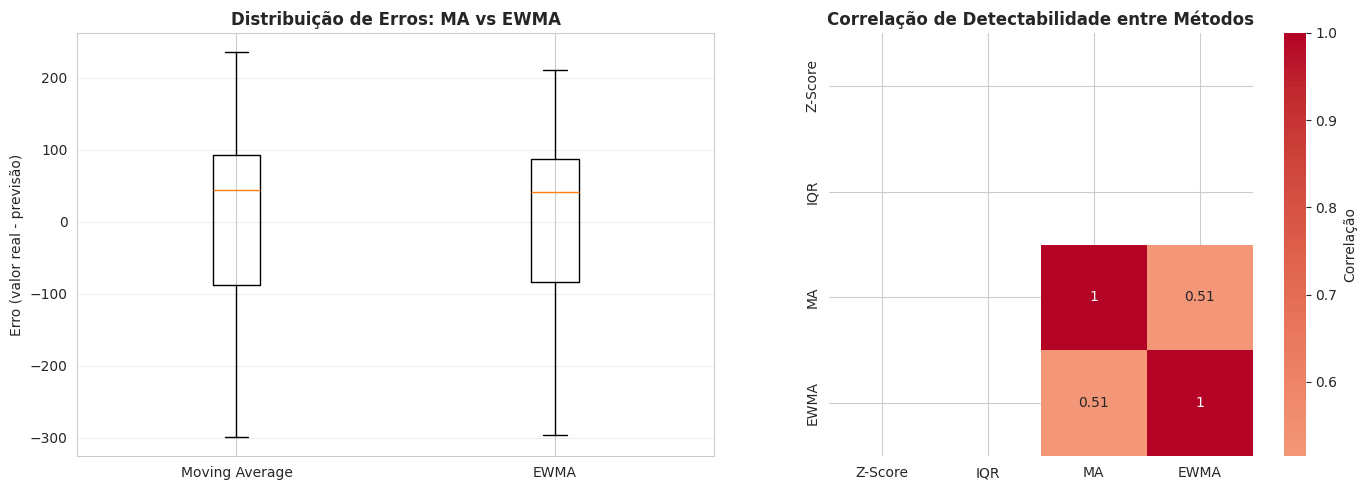


DIA 2 CONCLUÍDO!

Próximos passos:
  - Analisar quais métodos funcionaram melhor para seus dados
  - Ajustar thresholds se necessário
  - Dia 3: Métodos baseados em árvores e distância (IF, LOF, DBSCAN)


In [19]:
# ============================================================================
# BOX PLOT DE DISTRIBUIÇÃO DE ERROS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Erros Moving Average vs EWMA
axes[0].boxplot([ma_error.dropna(), ewma_error], labels=['Moving Average', 'EWMA'])
axes[0].set_title('Distribuição de Erros: MA vs EWMA', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Erro (valor real - previsão)')
axes[0].grid(True, alpha=0.3, axis='y')

# Heatmap de concordância entre métodos
agreement = anomaly_matrix[['Z-Score', 'IQR', 'MA', 'EWMA']].corr()
sns.heatmap(agreement, annot=True, cmap='coolwarm', center=0, 
           square=True, ax=axes[1], cbar_kws={'label': 'Correlação'})
axes[1].set_title('Correlação de Detectabilidade entre Métodos', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/plots/02_error_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/02_error_distribution.png")
plt.show()

print("\n" + "=" * 70)
print("DIA 2 CONCLUÍDO!")
print("=" * 70)
print("\nPróximos passos:")
print("  - Analisar quais métodos funcionaram melhor para seus dados")
print("  - Ajustar thresholds se necessário")
print("  - Dia 3: Métodos baseados em árvores e distância (IF, LOF, DBSCAN)")